## Loding data

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
df_train = pd.read_csv('data/x_train.csv', sep=';', index_col=None)
df_test = pd.read_csv('data/x_test.csv', sep=';', index_col=None)


In [3]:
print df_train.shape
print df_test.shape

(25289, 12)
(25289, 12)


#### So, the data is splitted by 50-50%
Let's concatenate the data for futher feature engeneering

In [4]:
# I dislike long column-names: replacing them
df = pd.concat([df_train, df_test])
df.columns = ['MaxLevel', 
                'AttemptLevels',
                'AttemptsMaxLevel',
                'Attempts', 
                'avgSteps',
                'returns',
                'numBonus',
                'fractionBonus',
                'score',
                'bonusScore',
                'stars',
                'days']



## Feature engineering

In [5]:
# for some numeric colums we wll calculate the overal counts of each possible values
for col in ['MaxLevel']:
    df[col + '_cnt'] = df[col].map(df[col].value_counts())
    

In [6]:
# this is the dictionary: how many attepts users made on the max level(in average)
dict = {k: np.mean(g["AttemptsMaxLevel"].tolist()) for k,g in df[['MaxLevel','AttemptsMaxLevel']].groupby('MaxLevel')}

TypeError: 'int' object has no attribute '__getitem__'

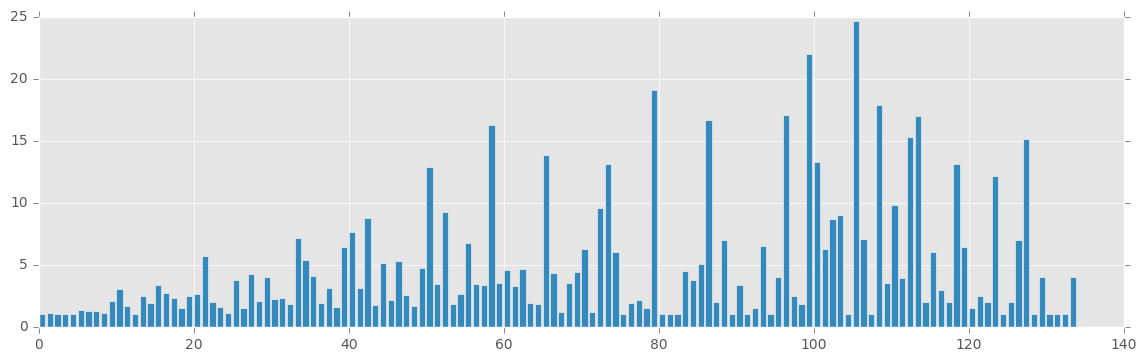

In [7]:
# The distribution tells nothing, probably we have small dataset
plt.figure(figsize(14,4))
plt.bar(range(len(dict)), dict.values())
plt.xticks(range(0, len(dict)[1,3]), dict.keys())
plt.show()

#### Calculating some useful columns relations

In [8]:

# average attempts the user made to pass the level 
def average_attemps_per_level(totalNumOfAttempts, attemptsOnTheHighestLevel, numberOfAttemptedLevels):
    return float(totalNumOfAttempts - attemptsOnTheHighestLevel)/numberOfAttemptedLevels 

#с какой скоростью в среднем игрок проходит уровни
# average progress speed
def prossed_per_period(levels_per_period, period):
    return float(levels_per_period)/period

# average attempts on the max level
def average_attemps_per_max_level(maxlevel):
    return dict[maxlevel] 

#### apply functions to get new columns

In [9]:
# среднее  число попыток, которое тратили люди на уровень
df['average_attemps_per_max_level'] = df['MaxLevel'].apply(average_attemps_per_max_level)

#с какой скоростью в среднем игрок проходит уровни
df['progress_speed'] = df.apply(
    lambda row: prossed_per_period(row['Attempts'],
                                   row['days']), axis = 1)

#сколько попыток в среднем уходи на 1 уровень(не максимальный)
df['avg_attemps_per_level'] = df.apply(
    lambda row: average_attemps_per_level(row['Attempts'],
                                          row['AttemptsMaxLevel'],
                                          row['AttemptLevels']), axis = 1)


In [10]:
#some other features
df['max_level*avgSteps'] = df.apply(lambda row: row['MaxLevel']*row['avgSteps'], axis = 1)
df['score_per_bonusScore'] = df.apply(lambda row: row['score']/row['bonusScore'], axis = 1)
df['score_per_bonusScore'].fillna('0.0', inplace=True)
df['score_per_bonusScore'].replace([np.inf, -np.inf], '0.0', inplace=True)
df.score_per_bonusScore = df.score_per_bonusScore.astype(float)

In [11]:
df_train = df.iloc[:df_train.shape[0], :]
df_test = df.iloc[-df_test.shape[0]:, :]

In [12]:
y_train = pd.read_csv("data/y_train.csv", sep=';',header=None)
y_train.columns = ['class'] 

In [13]:
data = pd.concat([df_train,y_train], axis=1)
target = "class"
predictors = data.drop(target, axis=1).columns

In [15]:
# probability of staing in the game
def probability(dictionary, column):
    res = 0
    try:
        try:
            res = dictionary[column][0]
        except:
            res = 1
            return res
        # stayed /(all people on this level)
        res = float(dictionary[column][1])/(dictionary[column][1] + dictionary[column][0])
    except:
        print 'except column', column
    return res

In [ ]:
dictMaxLevel = {k: g["class"].value_counts() for k, g in data.groupby('MaxLevel')}
# probability of staing in the game by level
data['probability_max_level'] = data.apply(lambda row: probability(dictMaxLevel, row['MaxLevel']), axis = 1)

except column 144.0
except column 80.0
except column 113.0


In [ ]:
dictDays = {k: g["class"].value_counts() for k,g in data.groupby('days')}
# probability of staing in the game by day
data['probability_day'] = data.apply(lambda row: probability(dictDays, row['days']), axis = 1)

In [ ]:
data.to_csv('data.csv', sep=';', decimal=",")

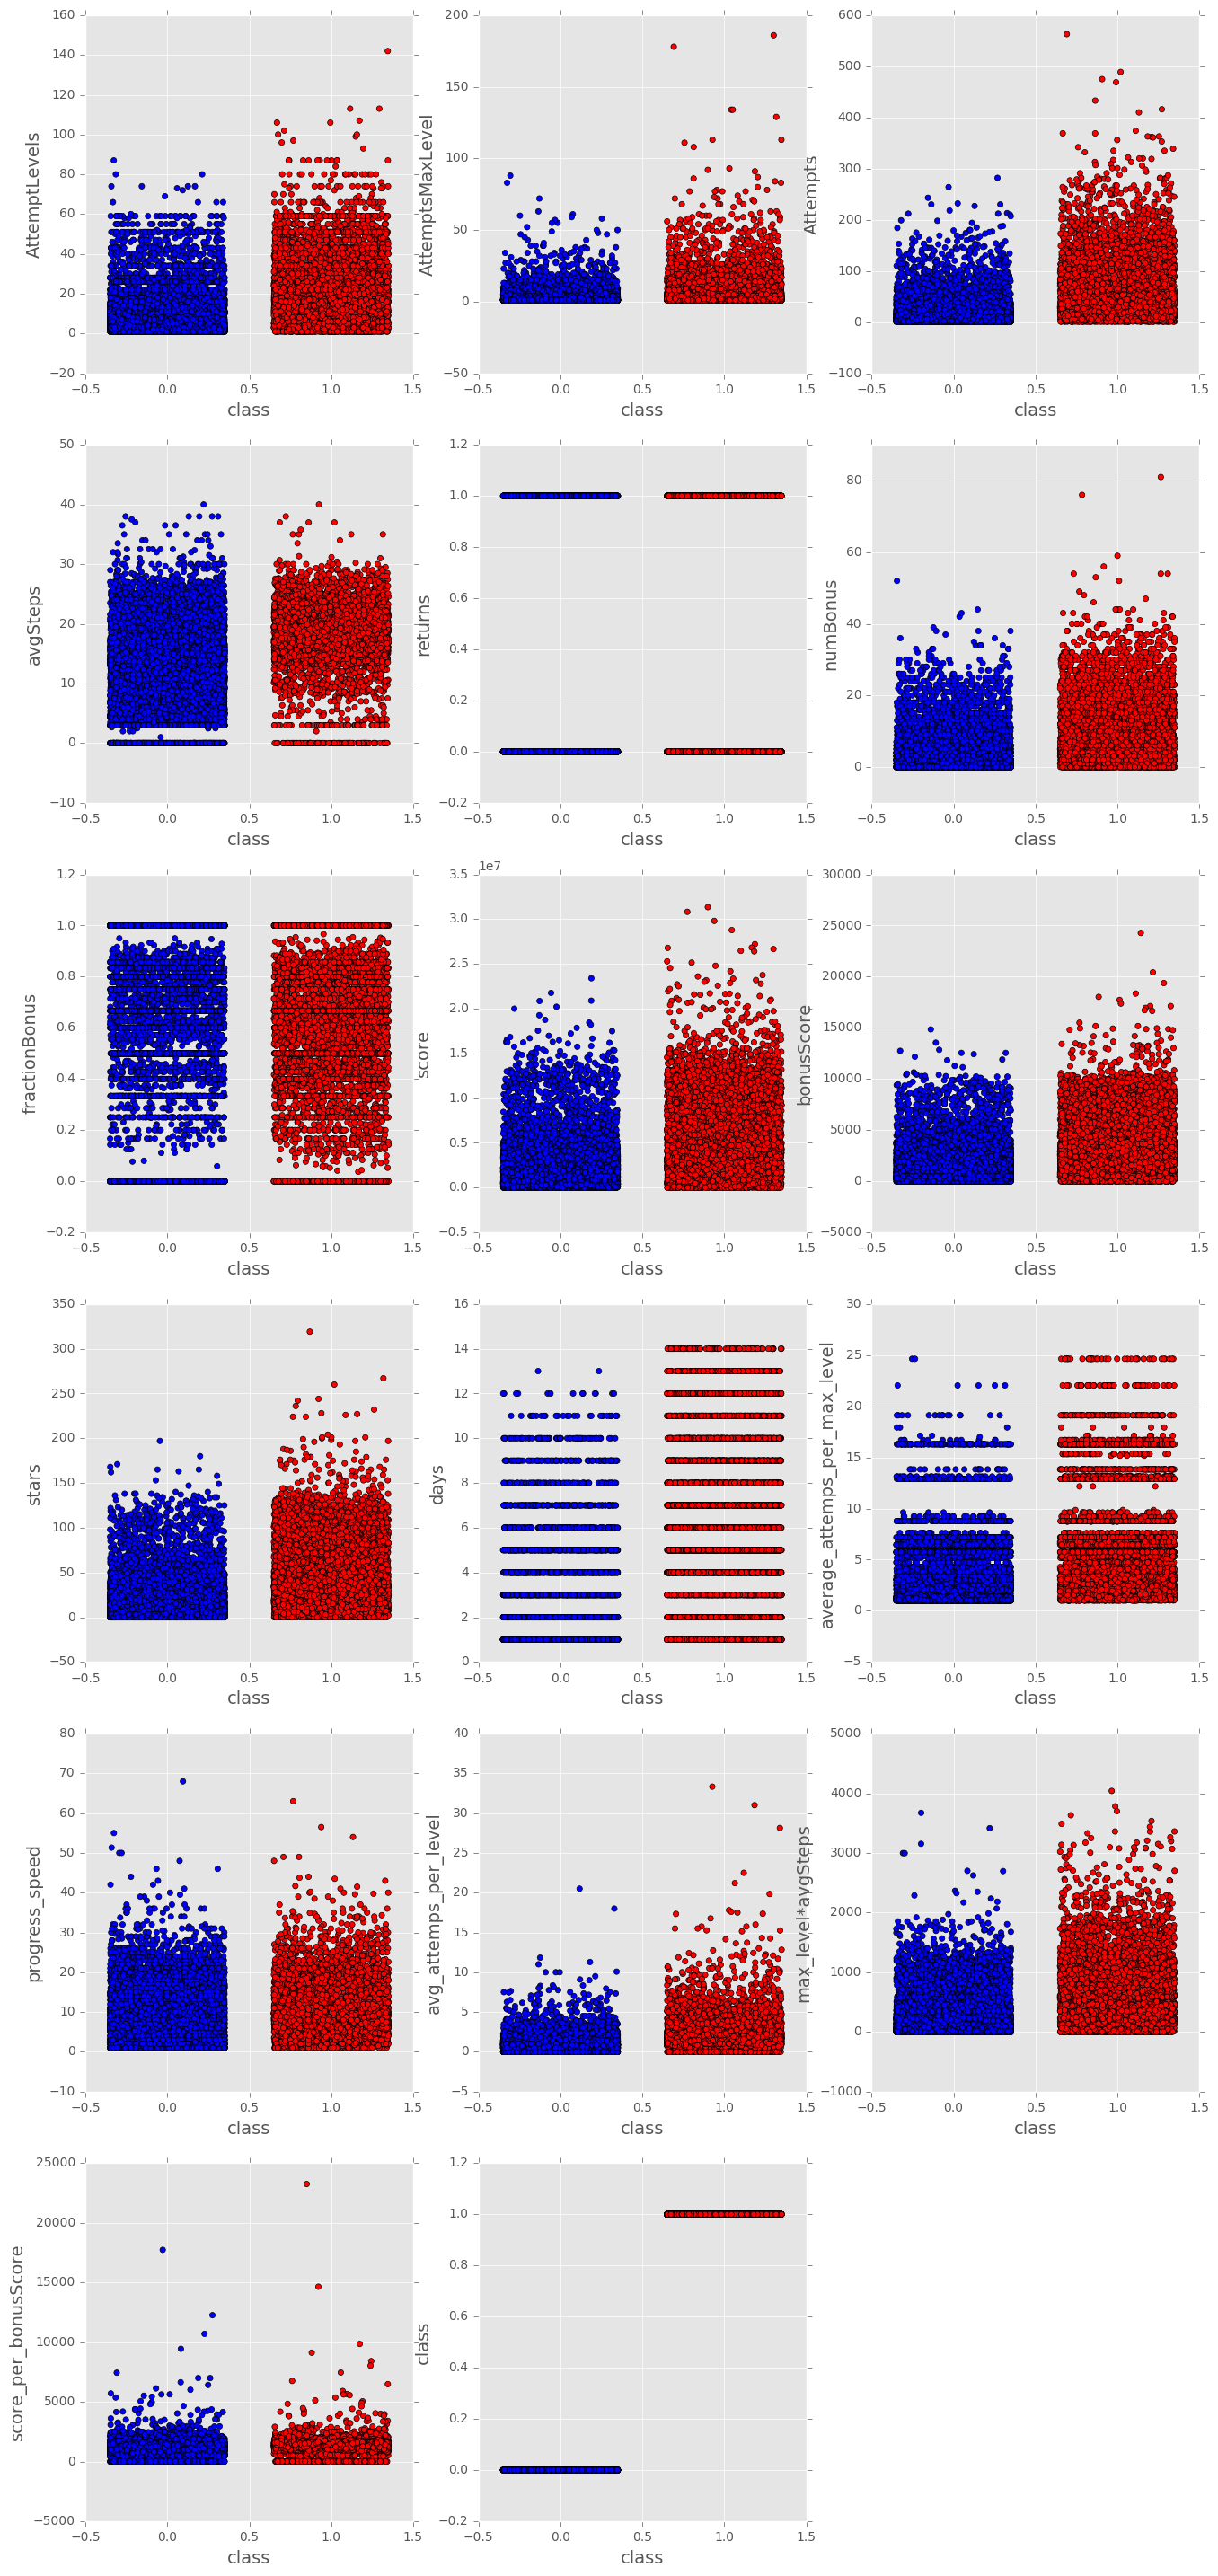

In [40]:
def jitter(arr):
    return arr + np.random.uniform(low=-0.35, high=0.35, size=len(arr))

def color(class_value):
    if(class_value == 1):
        return 'red'
    else:
        return 'blue'
    
pyplot.figure(figsize(16, 36))
for i in range (1, 18):
    pyplot.subplot(6, 3, i)
    pyplot.scatter(jitter(data['class']), data.ix[:, i], color=data["class"].apply(color), edgecolors="black")
    pyplot.xlabel('class', fontsize=14)
    pyplot.ylabel(str(data.columns[i]), fontsize=14)

In [41]:
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold,cross_val_score
from sklearn.metrics import log_loss

## XGBoost

In [42]:
#the model was obtained by hyperopt
clf_xgb = xgb.XGBClassifier(
                            colsample_bylevel = 0.9,
                            colsample_bytree = 1,
                            gamma = 4.6,
                            learning_rate = 0.01,
                            max_delta_step = 2.6,
                            max_depth =  5,
                            min_child_weight = 5.0,
                            n_estimators = 799,
                            nthread = 6,
                            objective = 'binary:logistic',
                            reg_lambda = 6.7,
                            scale_pos_weight = 1,
                            silent = 1,
                            subsample = 0.6,
                            seed=123)

In [43]:
# CV with 5 folds
skf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True)
i = 0
scores = []
for train_index, test_index in skf.split(data[predictors], data[target]):
    dtrain = data.loc[train_index, predictors]
    label = data.loc[train_index, target].astype(bool)
    dtest = data.loc[test_index, predictors]
    test_label = data.loc[test_index, target].astype(bool)  
    
    clf_xgb.fit(dtrain, label, eval_metric='logloss')
    
    y_pred = clf_xgb.predict_proba(dtest)
    score  = log_loss(test_label, y_pred)
    print('[{}]: {}'.format(i, score))
    scores.append(score)
    i += 1
scores = np.array(scores)
scores.mean(), scores.std()

[0]: 0.389450395458
[1]: 0.384633799551
[2]: 0.371399425882
[3]: 0.378824863257
[4]: 0.375541993443


(0.379970095518114, 0.006418757593093901)

In [46]:
X = df_train[predictors]
y = y_train['class']

In [47]:
%%time

clf_xgb.fit(X, y)


Wall time: 2min 39s


XGBClassifier(base_score=0.5, colsample_bylevel=0.9, colsample_bytree=1,
       gamma=4.6, learning_rate=0.01, max_delta_step=2.6, max_depth=5,
       min_child_weight=5.0, missing=None, n_estimators=799, nthread=6,
       objective='binary:logistic', reg_alpha=0, reg_lambda=6.7,
       scale_pos_weight=1, seed=123, silent=1, subsample=0.6)

In [48]:
y_predict = clf_xgb.predict_proba(df_test)

In [49]:
# the final submit was the average of 100 xgboost models with different random seed
df_pred = pd.DataFrame(y_predict[:,1])
df_pred.to_csv('submit_last.csv', index=None, header=None, float_format='%.6f')